### Objective
The objective of this study is to develop a vision-based vehicle detection system for intelligent driving. *The paper proposes a vision-based vehicle detection system for intelligent driving. By using low-quality images from a monocular camera mounted on the front of a vehicle, the system aims to accurately detect and avoid obstacles (like other vehicles) to prevent accidents.*

### Methodology
The detection system is built around a CNN, which can efficiently extract features from input images and provide accurate recognitionof vehicles in real-time. The paper explores different CNN architectures and compares their performance, demonstrating that thisapproach yields high accuracy in vehicle detection under varying conditions.

### Key Components:
- CNN is utilized for feature extraction, classification, and vehicle detection from road images.
- The system involves a multi-layer CNN structure with convolution, pooling, and fully connected layers.
- The CNN-based system’s performance is compared to other models, such as Support Vector Machines (SVM) and Fully Connected Neural Networks (FFNN), with CNN outperforming them.

##### 1. Import Libraries

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split

/Users/macbook/Documents/GitHub/my_vehicle_detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Version check
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Verify GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Configure memory growth for GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(e)

##### the CNN model has three convolutional layers followed by pooling layers and dense layers

### Load and Preprocess Images

In [5]:
# Set image dimensions
IMG_WIDTH, IMG_HEIGHT = 64, 64

# Load vehicle images and label them as 1
vehicle_paths = sorted(glob.glob('./VehicleImage/vehicles/*/*.png'))
vehicles = [cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)) for img in vehicle_paths]
vehicle_labels = [1] * len(vehicles)

# Load non-vehicle images and label them as 0
nonvehicle_paths = sorted(glob.glob('./VehicleImage/non-vehicles/*/*.png'))
nonvehicles = [cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)) for img in nonvehicle_paths]
nonvehicle_labels = [0] * len(nonvehicles)

# Combine data and labels
X = np.array(vehicles + nonvehicles)
y = np.array(vehicle_labels + nonvehicle_labels)

### 1. Split the Data

In [ ]:
# # Train-test split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Normalize the images
# X_train = X_train / 255.0
# X_val = X_val / 255.0

# # Convert labels to categorical format
# y_train = to_categorical(y_train, num_classes=2)
# y_val = to_categorical(y_val, num_classes=2)    

NameError: name 'X' is not defined

### 1.5 Split the Dataset into Training, Validation, and Testing Sets

In [6]:
from sklearn.model_selection import train_test_split

# Initial split: Training and temporary set (combined validation + test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Second split: Validation and training
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)
# 0.1765 * 0.85 ~= 0.15, so we end up with 70% train, 15% val, 15% test

# Normalize the images
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

#### Define the CNN Model


In [7]:
def create_cnn_model(input_shape=(64, 64, 3)):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    
    model.add(Dense(16, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    # Output Layer: 2 neurons (binary classification for "vehicle" or "no vehicle")
    model.add(Dense(2, activation='softmax'))
    
    return model

# Instantiate the model
model = create_cnn_model()
model.summary()

2024-10-30 14:52:58.441331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-30 14:52:58.441993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-30 14:52:58.442000: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-30 14:52:58.442629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 14:52:58.443214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        73,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,658 (690.07 KB)

 Trainable params: 176,658 (690.07 KB)

 Non-trainable params: 0 (0.00 B)

### Different CNN Design

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU
from tensorflow.keras.optimizers import Adam

def create_cnn_model_arch2(input_shape=(64, 64, 3)):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    
    model.add(Dense(16))
    model.add(ReLU())
    model.add(Dense(64))
    model.add(ReLU())
    model.add(Dense(128))
    model.add(ReLU())
    
    # Output Layer: 2 neurons (binary classification for "vehicle" or "no vehicle")
    model.add(Dense(2, activation='softmax'))
    
    return model

# Instantiate the model
model_arch2 = create_cnn_model_arch2()
model_arch2.summary()

In [ ]:
# compile model_arch2
model_arch2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

##### 3. Compile the Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# # Define paths for train and validation directories
# train_dir = '/path/to/train'  # Replace with your actual path
# validation_dir = '/path/to/validation'  # Replace with your actual path

# # Data Augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# validation_datagen = ImageDataGenerator(rescale=1.0/255)

# # Load Data
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='binary'
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='binary'
# )

##### 5. Train the Model

In [ ]:
# Ensure the model is defined by running the cell where the model is created and compiled
history = model_arch2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

##### 6.  Evaluate the Model

In [ ]:
# Evaluate model performance on validation data
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

##### 7. Make Predictions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_vehicle(model, img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    if np.argmax(prediction) == 0:
        print("No Vehicle Detected")
    else:
        print("Vehicle Detected")

# Test on a new image
predict_vehicle(model, '/path/to/test_image.jpg')

### Paper CNN Architecture

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model_arch3 = models.Sequential()

# Input layer
model_arch3.add(layers.Input(shape=(64, 64, 3)))

# Hidden layer 1
model_arch3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model_arch3.add(layers.MaxPooling2D((2, 2)))

# Hidden layer 2
model_arch3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_arch3.add(layers.MaxPooling2D((2, 2)))

# Hidden layer 3
model_arch3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_arch3.add(layers.MaxPooling2D((2, 2)))

# Classification layer
model_arch3.add(layers.Flatten())
model_arch3.add(layers.Dense(16, activation='relu'))
model_arch3.add(layers.Dense(64, activation='relu'))
model_arch3.add(layers.Dense(128, activation='relu'))
model_arch3.add(layers.Dense(2, activation='softmax'))

# Compile the model_arch3
model_arch3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model_arch3
model_arch3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │       131,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,002 (914.07 KB)

 Trainable params: 234,002 (914.07 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# compile the model
model_arch3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# fit thte model
history = model_arch3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50


2024-10-30 14:54:04.507886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7350 - loss: 0.4837 - val_accuracy: 0.9263 - val_loss: 0.1912
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9650 - loss: 0.1051 - val_accuracy: 0.9727 - val_loss: 0.0868
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9799 - loss: 0.0616 - val_accuracy: 0.9763 - val_loss: 0.0649
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9894 - loss: 0.0371 - val_accuracy: 0.9818 - val_loss: 0.0648
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9856 - loss: 0.0389 - val_accuracy: 0.9663 - val_loss: 0.0868
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9726 - loss: 0.0687 - val_accuracy: 0.9754 - val_loss: 0.0808
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9890 - loss: 0.0269 - val_accuracy: 0.9873 - val_loss: 0.0494
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9925 - loss: 0.0207 - val_accuracy: 0.98

In [11]:
# Evaluate model performance on validation data
loss, accuracy = model_arch3.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9929 - loss: 0.0892
Validation Loss: 0.13901153206825256
Validation Accuracy: 0.9890809655189514


## analyze the model’s performance in detail

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Make Predictions on the Test Set


In [13]:
# Predict probabilities
y_pred_probs = model_arch3.predict(X_test)
# Convert probabilities to binary predictions (0 or 1 for non-vehicle or vehicle)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # True labels

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Step 3: Calculate and Interpret Metrics

In [14]:
# 1. Accuracy: Measures the proportion of correct predictions (both positive and negative) out of the total predictions.
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9881710646041856


- Interpretation:
    - Accuracy shows the overall correctness but may be misleading if there is class imbalance.

In [15]:
# 2. Precision: Measures the proportion of true positive predictions out of all positive predictions. High precision indicates that the model is good at minimizing false positives.
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")



Precision: 0.9845261121856866


- Interpretation: 
    - Precision is useful when false positives are costly. In vehicle detection, low precision would mean the model often misclassifies non-vehicles as vehicles.

In [16]:
# 3. Recall (Sensitivity): Measures the proportion of true positive predictions out of all actual positives. High recall indicates that the model is good at minimizing false negatives.
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")


Recall: 0.9902723735408561


- Interpretation: 
  - Recall is useful when false negatives are costly. In vehicle detection, low recall would mean the model misses vehicles on the road.


In [17]:
#4.	F1 Score: The harmonic mean of precision and recall. It balances the two metrics and is useful when you need to account for both false positives and false negatives.
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")


F1 Score: 0.9873908826382153


- Interpretation: A higher F1 score indicates a good balance between precision and recall.


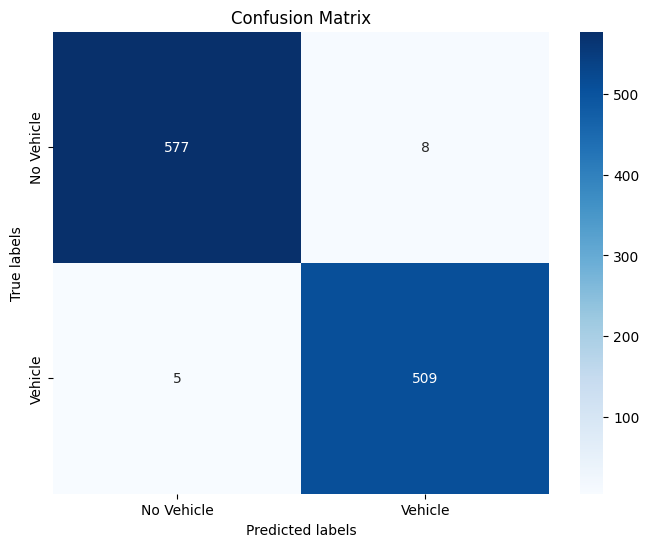

In [18]:
#5.	Confusion Matrix: Provides a summary of true positive, false positive, true negative, and false negative counts.


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Vehicle', 'Vehicle'], yticklabels=['No Vehicle', 'Vehicle'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# chatgpt ouput
# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


- Interpretation: The confusion matrix gives a breakdown of correct and incorrect predictions by class.
	- True Positives (TP): Correctly classified vehicles.
	- True Negatives (TN): Correctly classified non-vehicles.
	- False Positives (FP): Non-vehicles misclassified as vehicles.
	- False Negatives (FN): Vehicles misclassified as non-vehicles.


In [19]:
#6.	Classification Report: Provides a summary of precision, recall, F1 score, and support for each class.
print(classification_report(y_true, y_pred, target_names=['No Vehicle', 'Vehicle']))

              precision    recall  f1-score   support

  No Vehicle       0.99      0.99      0.99       585
     Vehicle       0.98      0.99      0.99       514

    accuracy                           0.99      1099
   macro avg       0.99      0.99      0.99      1099
weighted avg       0.99      0.99      0.99      1099



- Interpretation: The classification report gives you detailed performance metrics for each class, helping to understand which class the model struggles with.
